In [1]:
from queries import*
from utilities import*
import os
from sklearn import svm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

import shap
from sklearn.cross_decomposition import CCA
import seaborn as sns

# Directory

In [2]:
directory = './data/output/'
output_directory = os.listdir(directory)
nodes_features = pd.DataFrame({})
laplace_quadratics_features = pd.DataFrame({})

for folder in output_directory[:]:
    if folder.startswith('DEEPMEL'):
        
        nodes_stats = pd.read_csv(directory + folder +'/'+ 'nodes_stats.csv') 
        laplace_quadratics = pd.read_csv(directory + folder +'/'+ 'laplace_quadratic_form_high_level_graph.csv')
        
        nodes_features = pd.concat([nodes_features,nodes_stats])
        laplace_quadratics_features = pd.concat([laplace_quadratics_features,laplace_quadratics])
        
        


In [3]:
PLOT_DIRECTORY = './plots/ANALYSIS/'

# Adding Labels 

In [4]:
def labeling(string):
    Patients_CR = ['1C', '1Y', '1N', '1J', '2Y', '1O', '1P','3H','1T','3M','3D','2A','2F','1R']

    if str(string)[0:2] in Patients_CR:
        return 1
    else:
        return 0

In [5]:
def cleaning(name):
    dictio = {30:'3E1',10:'1E1'}
    if name in [30.0,10.0]:
        return dictio[int(name)]
    else :
        return name

In [6]:
nodes_features['name'] = nodes_features.name.apply(lambda x: cleaning(x))
nodes_features['label'] = nodes_features.name.apply(lambda x: labeling(x))

laplace_quadratics_features['name']  =  nodes_features.name.values
laplace_quadratics_features['label'] =  laplace_quadratics_features.name.apply(lambda x: labeling(x))

In [7]:
nodes_features = nodes_features.fillna(0)

In [8]:
laplace_quadratics_features.head()

,cell_x_position,cell_y_position,tumor_degree,stroma_degree,missing_degree,total_degree,MISSING_degree,tumor_pheno_degree,stroma_pheno_degree,macrophages_degree,...,dendtritic_degree,dendtritic-B,dendtritic-MISSING,dendtritic-T,dendtritic-dendtritic,macrophages-dendtritic,stroma-dendtritic,tumor-dendtritic,name,label
0,0.120439,0.092360,6.572108,4.058740,0.182660,6.690847,8.342422,6.830195,2.868956,7.736257,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3P1,0
0,0.303528,0.108709,1.834556,7.280360,2.616268,3.246083,5.142674,5.113967,7.340761,12.050398,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3F1,0
0,0.444019,0.451170,5.391260,2.914826,2.595107,2.358629,6.747681,7.854818,2.357863,3.131440,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1L1,0
0,0.254177,0.267382,8.204733,15.897033,6.156923,17.868978,5.602707,10.701520,15.458352,15.629805,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3M1,1
0,1.934097,0.766486,3.636884,2.857254,4.656358,3.627077,5.973440,4.766585,2.894964,5.822773,...,8.92317,7.650551,8.718349,7.087693,8.068412,3.958368,6.617321,9.191675,1K1,0


# Analysis on nodes features 

## Correlation analysis

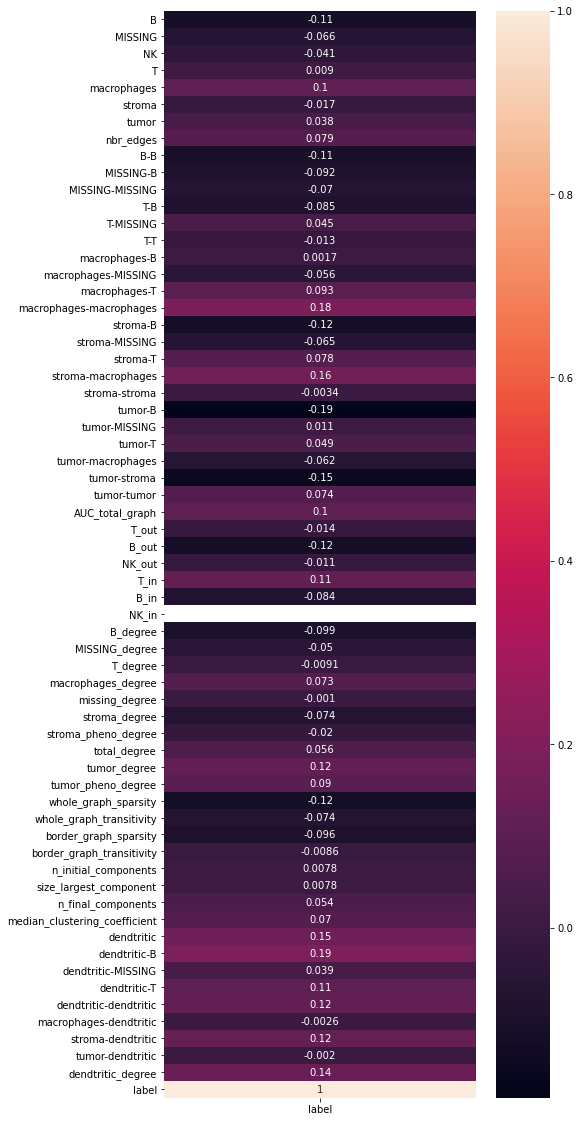

In [9]:
correlation_nodes = nodes_features.corr()
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,63:],annot=True)

In [39]:
def scatter_analysis(nodes_features_bool,x_name,y_name, hue = None):
    
    if nodes_features_bool:
        plt.figure(figsize=(15,7))
        plot_name = PLOT_DIRECTORY +'nodes_features_scatter_'+x_name +'_'+ y_name +'.png'
        ax =sns.scatterplot(data=nodes_features, x= x_name, y=y_name, hue=hue)
        plt.savefig(plot_name)
        
        
    else:
        
        plt.figure(figsize=(15,7))
        plot_name = PLOT_DIRECTORY +'laplace_'+x_name +'_vs_'+ y_name +'.png'
        ax = sns.scatterplot(data=laplace_quadratics_features, x=x_name,y=y_name, hue = hue)
        plt.savefig(plot_name)
            
            
            

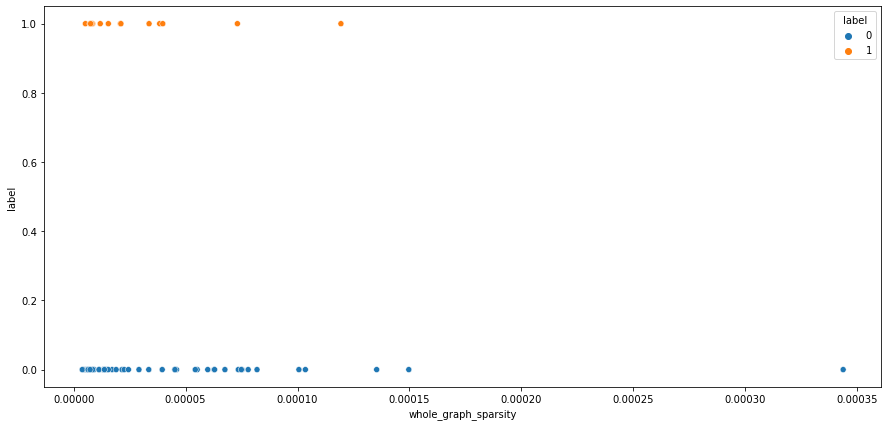

In [40]:
scatter_analysis(True,'whole_graph_sparsity','label',hue='label')

<AxesSubplot:xlabel='T_in', ylabel='T_out'>

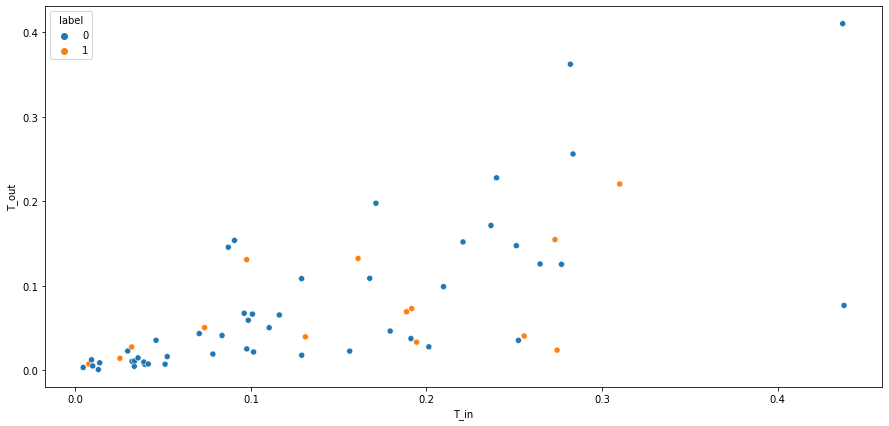

In [12]:
plt.figure(figsize=(15,7))

sns.scatterplot(x='T_in',y='T_out',data = nodes_features, hue='label')

## Principal component analysis 

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
label = nodes_features.label.values
features_scaled= nodes_features.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

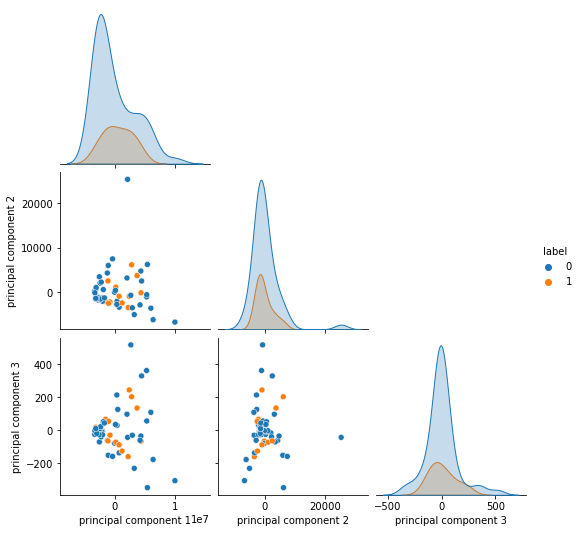

In [14]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'nodes_features_PCA.png')

In [15]:
pca.explained_variance_

array([1.01656942e+13, 1.87554594e+07, 1.92363115e+04])

## Support vector machine

In [16]:
X = nodes_features.iloc[:,2:63]
y = nodes_features.label.values
clf = svm.SVC()
clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [14,  0]])

In [17]:
#!pip install xgboost
#!pip install shap

## Logistic regression

In [18]:
clf = LogisticRegression(random_state=0).fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [14,  0]])

## Random forest

In [25]:
model = RandomForestClassifier(max_depth=4, random_state=0)
model.fit(X, y)
y_pred = model.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

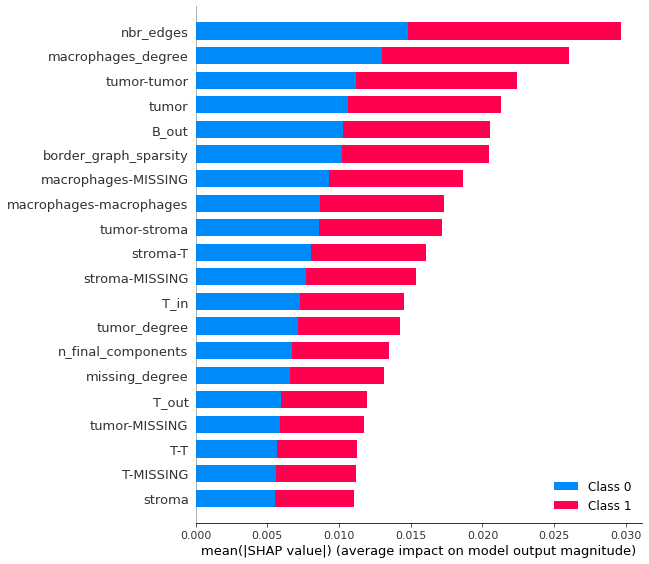

In [26]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)

# Laplace Quadtratic features

## Correlation analysis

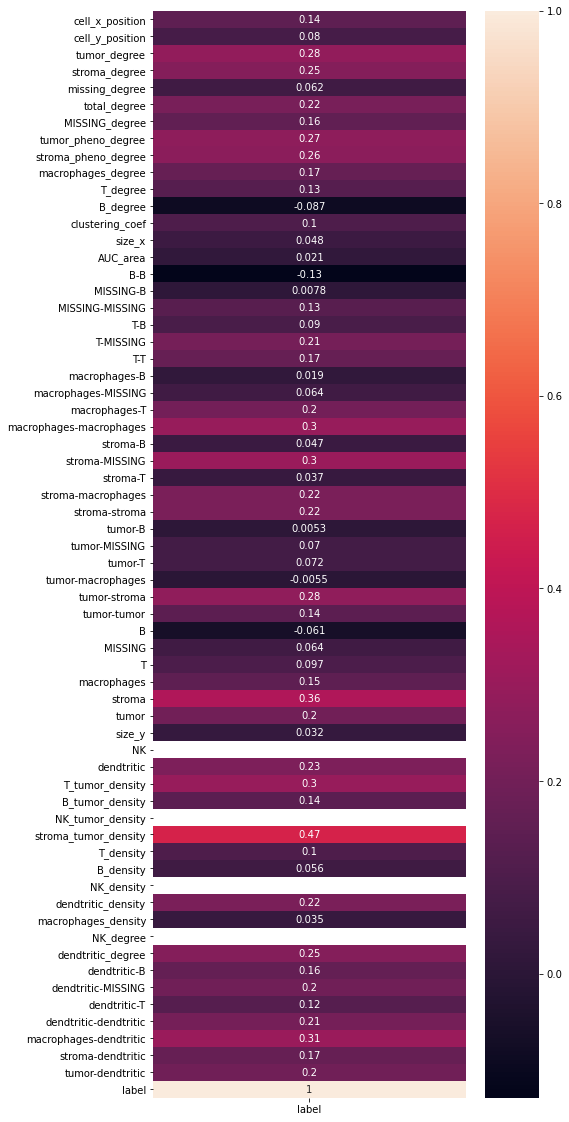

In [28]:
correlation_nodes = laplace_quadratics_features.corr()
f, ax = plt.subplots(figsize=(7, 20))
ax = sns.heatmap(correlation_nodes.iloc[:,63:],annot=True)
ax.savefig(PLOT_DIRECTORY + '')

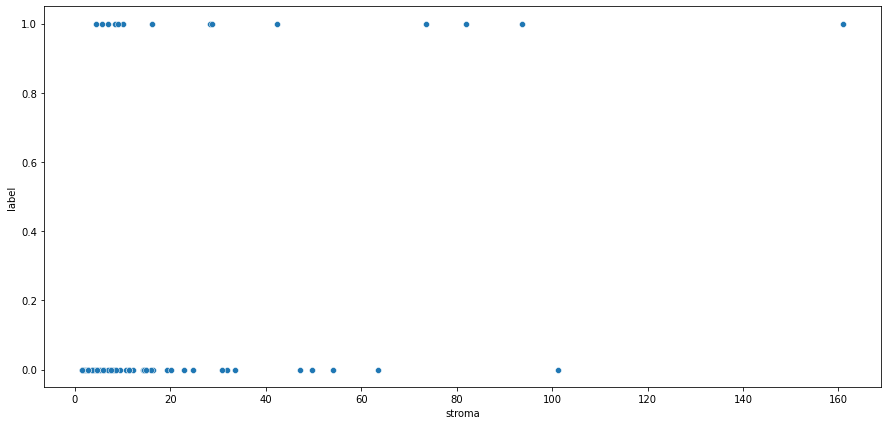

In [34]:
scatter_analysis(False,'stroma','label')

<AxesSubplot:xlabel='stroma_tumor_density', ylabel='macrophages-dendtritic'>

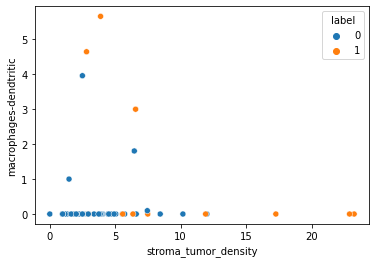

In [38]:
sns.scatterplot(data = laplace_quadratics_features, x = 'stroma_tumor_density', y = 'macrophages-dendtritic', hue='label')

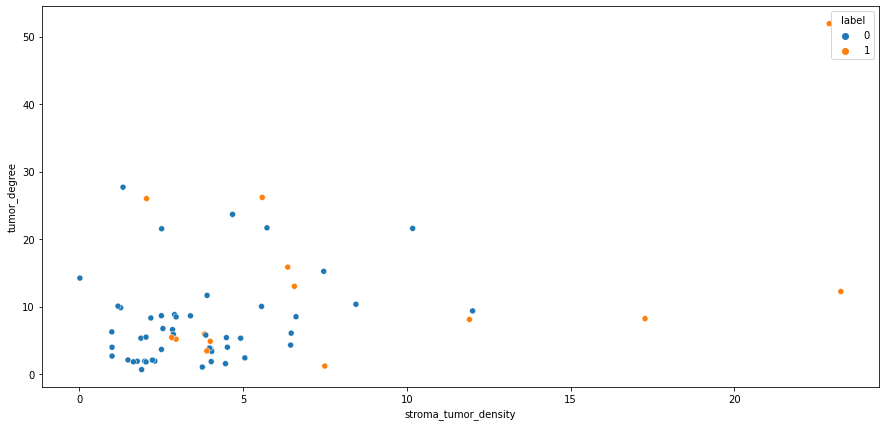

In [42]:
scatter_analysis(False,'stroma_tumor_density','tumor_degree',hue='label')

## Principal component analysis

In [43]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
label = laplace_quadratics_features.label.values
features_scaled= laplace_quadratics_features.drop(['name','label'],axis=1)
principalComponents = pca.fit_transform(features_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2','principal component 3'])
principalDf['label'] = label

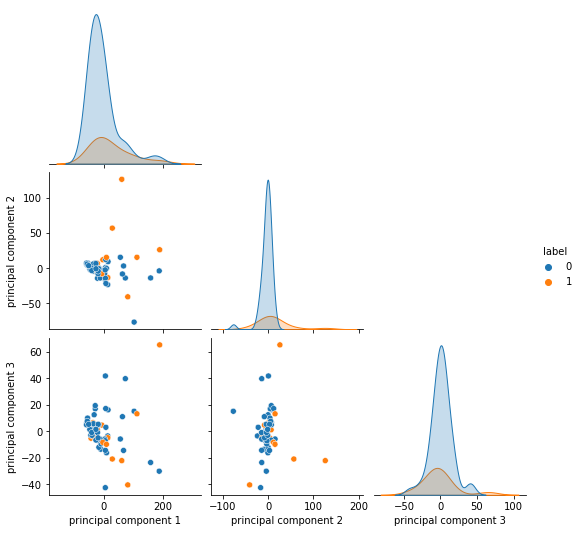

In [44]:
sns.pairplot(principalDf, hue='label', corner =True).savefig(PLOT_DIRECTORY+'Laplace_PCA.png')

## Support vector machine

In [45]:
X = laplace_quadratics_features.iloc[:,2:63]
y = laplace_quadratics_features.label.values
clf = svm.SVC()
clf.fit(X,y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 9,  5]])

## Logistic regression

In [46]:
clf = LogisticRegression(random_state=0).fit(X, y)
y_pred = clf.predict(X)
confusion_matrix(y,y_pred)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([[49,  0],
       [ 0, 14]])

## Random forest

In [48]:
model = RandomForestClassifier(max_depth=6, random_state=0)
model.fit(X, y)
y_pred = model.predict(X)
confusion_matrix(y,y_pred)

array([[49,  0],
       [ 0, 14]])

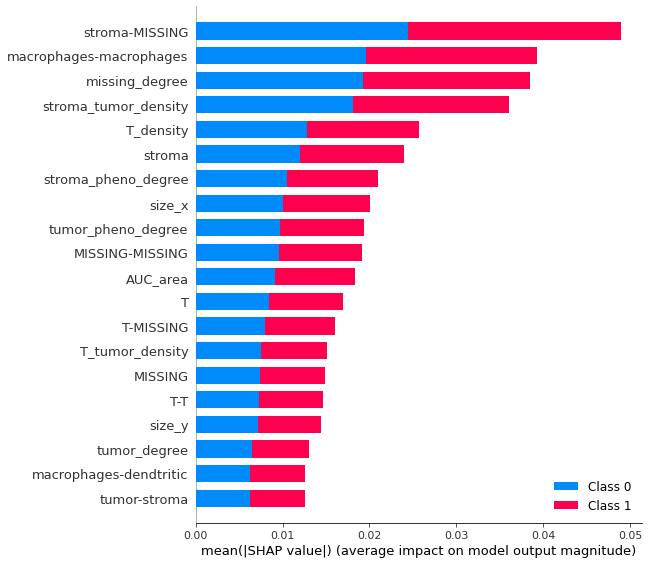

In [49]:
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features=X, feature_names=X.columns)